In [1]:
import importlib
from moma_analysis import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

TINY_SIZE = 6
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

textwidth = 5.8 # inches
textheight = 8.2 # inches

In [6]:
# load dataset
ds = 2
paths = {1:'data/191120_traces.csv', 2:'data/200114_traces_select_new.csv', 3:'data/200617_traces.csv'}
df = pd.read_csv(paths[ds])

fs = 6
t_cutoff = 50
if ds==3:
    t_cutoff = 35

# selection of traces
selection = df['id'].unique()  # all
# For now only use traces that look good right away, comment if wanted
#for val in [17, 20, 40, 53, 3]:
#    selection = selection[selection!=val]
# individual selection
#selection = [59,89]

# initialise features to be collected per trace
T = []
peaks = []
dec = []
rsq = []
intervals = []
av_g_intervals = []
av_g_period = []
phases = np.zeros((len(selection), fs*t_cutoff))

# loop over selection
for j, i in enumerate(selection):
    # calculate phases
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    cutoff_freq = 1/5
    s_lp = butter_lowpass_filter_noshift(s_interp, cutoff_freq, 6, order=2)
    window_length = 21
    #s_smooth = savgol_filter(s_interp, window_length, 3, mode='interp')
    s_smooth = savgol_filter(s_lp, window_length, 3, mode='interp')
    s_analytical = hilbert(s_smooth)
    #s_analytical = hilbert(s_lp)
    phases[j] = np.angle(s_analytical)

    
    # calculate decay
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_smooth = savgol_filter(s_interp, 31, 3)
    peaks_i, T_i = peak_locations(s_smooth, 6)
    dec_i, rsq_i, intervals_i = peak_decay(peaks_i, T_i, t_interp, s_interp, i)
    intervals.append(intervals_i)
    T.append(T_i)
    peaks.append(peaks_i)
    dec.append(dec_i)
    rsq.append(rsq_i)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
    else: 
        g_rate_switch = g_rate
    
    # calculate average growth rate in intervals of peak decay
    av_g_intervals_i = []
    for interval in intervals_i:
        indices = (6*interval).astype(int)
        av_g_intervals_i.append(np.mean(g_rate_switch[indices[0]:indices[1]]))
    av_g_intervals.append(av_g_intervals_i)
    
    # calculate average growth rate of period
    av_g_period_i = []
    for i in range(len(T_i)):
        indices = [(fs*peaks_i[i]).astype(int), (fs*peaks_i[i+1]).astype(int)]
        av_g_period_i.append(np.mean(g_rate_switch[indices[0]:indices[1]]))
    av_g_period.append(av_g_period_i)
    

    
# ACF and xcorr

crosscorr_sum = np.zeros(fs*t_cutoff)
autocorr_growth_sum = np.zeros(fs*t_cutoff)
autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
    crosscorr_sum += crosscorr(s_interp, g_interp)

crosscorr_avg = crosscorr_sum/len(selection)
autocorr_avg = autocorr_sum/len(selection)
autocorr_growth_avg = autocorr_growth_sum/len(selection)


# collect features
av_g_intervals = np.concatenate(np.array(av_g_intervals))
av_g_period = np.concatenate(np.array(av_g_period))
# handle empty intervals
delete_empty_elements = []
intervals = np.array(intervals)
for i, interval in enumerate(intervals):
    if interval.shape==(0,):
        delete_empty_elements.append(i)
intervals = np.delete(intervals, delete_empty_elements)
intervals = np.concatenate(np.array(intervals))
Ti = T.copy()
T = np.concatenate(np.array(T))
dec = np.concatenate(np.array(dec))
rsq = np.concatenate(np.array(rsq))
uphases = np.unwrap(phases)
# does the following make sense?
phases0 = np.zeros_like(phases)
uphases0 = np.zeros_like(uphases)
for i in range(len(selection)):
    uphases0[i] = uphases[i]-uphases[i,0]
    phases0[i] = phases[i]-phases[i,0]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\ga25tom\Dropbox\CRISPR_Oscillator\Preparation\repressilator_refactored\moma_analysis.py:213: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*(x-c)) + d


No fit for id 11 peak 1
No fit for id 37 peak 2
No fit for id 50 peak 2


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


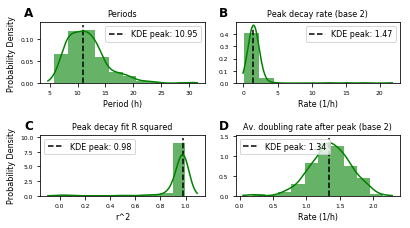

In [93]:
fig, axs = plt.subplots(2,2,figsize=(textwidth,.4*textheight))

hist_kde_oo(axs[0,0], T, 'Periods')
axs[0,0].set_xlabel('Period (h)')
axs[0,0].set_ylabel('Probability Density')

hist_kde_oo(axs[0,1], dec/np.log(2), 'Peak decay rate (base 2)')
axs[0,1].set_xlabel('Rate (1/h)')

hist_kde_oo(axs[1,0], rsq[rsq>0], 'Peak decay fit R squared')
axs[1,0].set_ylabel('Probability Density')
axs[1,0].set_xlabel('r^2')

hist_kde_oo(axs[1,1], av_g_intervals, 'Av. doubling rate after peak (base 2)')
axs[1,1].set_xlabel('Rate (1/h)')

fig.set_tight_layout('tight')

subplot_labels_oo(axs)
    
plt.savefig(f'figs/si/{ds}hist.png', dpi=600)
plt.savefig(f'figs/si/{ds}hist.pdf', transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


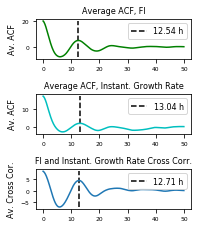

In [7]:
fig, axs = plt.subplots(3,1,figsize=(.5*textwidth,.4*textheight))

axs[0].plot(t_interp, autocorr_avg, 'g-')
#plt.plot(t_interp, autocorr_growth_avg, label=f'growth, N = {len(selection)}')
#T_max = 1/freq_from_autocorr(autocorr_avg, 6)
T_max = t_interp[int(autocorr_first_peak(autocorr_avg[:150]))]
axs[0].vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
axs[0].set_ylabel('Av. ACF')
axs[0].set_title('Average ACF, FI')
axs[0].legend()

axs[1].plot(t_g_interp, autocorr_growth_avg, 'c-')
T_max_g = t_g_interp[int(autocorr_first_peak(autocorr_growth_avg[:150]))]
axs[1].vlines(T_max_g, ymin=np.min(autocorr_growth_avg), ymax=np.max(autocorr_growth_avg), label=f'{T_max_g:.2f} h', linestyles='dashed')
axs[1].set_ylabel('Av. ACF')
axs[1].set_title('Average ACF, Instant. Growth Rate')
axs[1].legend()

axs[2].set_ylabel('Av. Cross Cor.')
axs[2].set_title(f'FI and Instant. Growth Rate Cross Corr.')
axs[2].plot(t_interp, crosscorr_avg)
T_max = t_interp[int(autocorr_first_peak(crosscorr_avg[:100]))]
axs[2].vlines(T_max, ymin=np.min(crosscorr_avg), ymax=np.max(crosscorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
axs[2].legend()


fig.set_tight_layout('tight')

#subplot_labels_oo(axs)

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

plt.savefig(f'figs/si/{ds}acf.png', dpi=600)
plt.savefig(f'figs/si/{ds}acf.pdf', transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


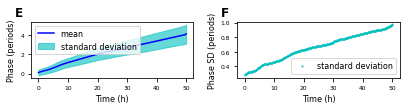

In [104]:
fig, axs = plt.subplots(1,2,figsize=(textwidth,.2*textheight))

y = np.mean(uphases, axis=0)/(2*np.pi)
yerr = np.std(uphases, axis=0)/(2*np.pi)
axs[0].plot(t_interp, y, 'b-', label=f'mean')
axs[0].set_ylabel('Phase (periods)')
axs[0].set_xlabel('Time (h)')
axs[0].fill_between(t_interp, y-yerr, y+yerr, alpha=0.6, color='c', label='standard deviation')
axs[0].legend()

axs[1].plot(t_interp, np.std(uphases, axis=0)/(2*np.pi), 'c.', ms=2, label='standard deviation')
#plt.plot(t_interp, fit_func(t_interp, *popt)/(2*np.pi), 'k-', label='f(x) = a*x^b\nfit: a=%5.3f, b=%5.3f' % tuple(popt))
axs[1].legend()
axs[1].set_xlabel('Time (h)')
axs[1].set_ylabel('Phase SD (periods)')

for n, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n+4], transform=ax.transAxes, 
            size=12, weight='bold')

fig.set_tight_layout('tight')
plt.savefig(f'figs/si/{ds}phase.png', dpi=600)
plt.savefig(f'figs/si/{ds}phase.pdf', transparent=True)

In [11]:
T_avg = (t_interp[-1] - t[0])/(y[-1] - y[0])
print(f'Average period from phase analysis: {T_avg}h (from slope of phase over time curve)')

Average period from phase analysis: 12.560474318036027h (from slope of phase over time curve)


In [ ]:
# Traces: FI, phase, area/division, growth

for j, i in enumerate(selection):
    # calculate phases
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    cutoff_freq = 1/5
    s_lp = butter_lowpass_filter_noshift(s_interp, cutoff_freq, 6, order=2)
    window_length = 21
    #s_smooth = savgol_filter(s_interp, window_length, 3, mode='interp')
    s_smooth = savgol_filter(s_lp, window_length, 3, mode='interp')
    s_analytical = hilbert(s_smooth)
    #s_analytical = hilbert(s_lp)
    phase = np.angle(s_analytical)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp_nonorm(g_rate_switch, t_switch, t_cutoff, fs)

    
    plt.figure(figsize=(textwidth,.2*textheight))
    plt.subplot(131)
    plt.plot(t_interp, s_interp)
    plt.xlabel('Time (h)')
    plt.ylabel('F.I. (a.u.)')
    
    plt.subplot(132)
    plt.plot(t_interp, phase)
    plt.xlabel('Time (h)')
    plt.ylabel('Instant. Phase')
    
    plt.subplot(133)
    plt.plot(t_g_interp, g_interp)
    plt.xlabel('Time (h)')
    plt.ylabel('Growth Rate (1/h)')
    
    plt.tight_layout()
    plt.savefig(f'figs/si/{ds}trace{j}.png', dpi=600)
    plt.savefig(f'figs/si/{ds}trace{j}.pdf', transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


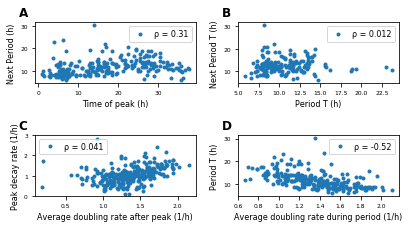

In [68]:
fig, axs = plt.subplots(2,2,figsize=(textwidth,.4*textheight))

period = []
time = []
for i in range(len(Ti)):
    for j in range(len(Ti[i])):
        period.append(Ti[i][j])
        time.append(peaks[i][j])

axs[0,0].plot(time, period, '.', label=f'ρ = {np.corrcoef(period, time)[0,1]:.2g}')
#plt.plot([7.5,25],[7.5,25], 'b--')
axs[0,0].set_xlabel('Time of peak (h)')
axs[0,0].set_ylabel('Next Period (h)')
axs[0,0].legend()


period = []
prev_period = []
for i in range(len(Ti)):
    for j in range(len(Ti[i]))[1:]:
        period.append(Ti[i][j])
        prev_period.append(Ti[i][j-1])

axs[0,1].plot(prev_period, period, '.', label=f'ρ = {np.corrcoef(prev_period, period)[0,1]:.2g}')
axs[0,1].set_xlabel('Period T (h)')
axs[0,1].set_ylabel('Next Period T (h)')
axs[0,1].legend()

axs[1,0].plot(av_g_intervals, dec, '.', label=f'ρ = {np.corrcoef(av_g_intervals, dec)[0,1]:.2g}')
axs[1,0].set_ylim([0,3])
axs[1,0].set_ylabel('Peak decay rate (1/h)')
axs[1,0].set_xlabel('Average doubling rate after peak (1/h)')
axs[1,0].legend()

axs[1,1].plot(av_g_period, T, '.', label=f'ρ = {np.corrcoef(av_g_period, T)[0,1]:.2g}')
axs[1,1].set_ylabel('Period T (h)')
axs[1,1].set_xlabel('Average doubling rate during period (1/h)')
axs[1,1].legend()

subplot_labels_oo(axs)

fig.set_tight_layout('tight')

plt.savefig(f'figs/si/{ds}corr.png', dpi=600)
plt.savefig(f'figs/si/{ds}corr.pdf', transparent=True)

In [19]:
no_period = 0
for i in range(len(Ti)):
    if (len(Ti[i]))<2:
        no_period += 1
print(f'Percentage of traces with two or more periods: {100 - 100*no_period/len(Ti):.1f}%')

Percentage of traces with two or more periods: 95.8%


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


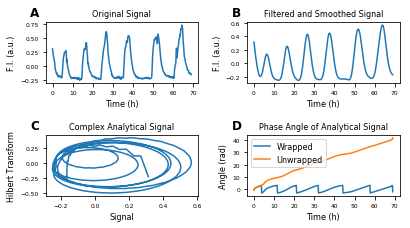

In [70]:
selection = df['id'].unique()
fs = 6
t_cutoff = 69
i = 6
name, t, sig = load_data(i, df)
t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)

# calculate phases
cutoff_freq = 1/5
s_lp = butter_lowpass_filter_noshift(s_interp, cutoff_freq, 6, order=2)
window_length = 21
s_smooth = savgol_filter(s_lp, window_length, 3, mode='interp')
s_analytical = hilbert(s_smooth)
#s_analytical = hilbert(s_lp)
s_phase = np.angle(s_analytical)


fig, axs = plt.subplots(2,2,figsize=(textwidth,.4*textheight))

axs[0,0].set_title('Original Signal')
axs[0,0].plot(t_interp, s_interp)
axs[0,0].set_xlabel('Time (h)')
axs[0,0].set_ylabel('F.I. (a.u.)')

axs[0,1].set_title('Filtered and Smoothed Signal')
axs[0,1].plot(t_interp, s_smooth)
axs[0,1].set_xlabel('Time (h)')
axs[0,1].set_ylabel('F.I. (a.u.)')

axs[1,0].set_title('Complex Analytical Signal')
axs[1,0].plot(np.real(s_analytical), np.imag(s_analytical))
axs[1,0].set_xlabel('Signal')
axs[1,0].set_ylabel('Hilbert Transform')

axs[1,1].set_title('Phase Angle of Analytical Signal')
axs[1,1].plot(t_interp, s_phase, label='Wrapped')
axs[1,1].plot(t_interp, np.unwrap(s_phase), label='Unwrapped')
axs[1,1].set_xlabel('Time (h)')
axs[1,1].set_ylabel('Angle (rad)')
axs[1,1].legend()


subplot_labels_oo(axs)
fig.set_tight_layout('tight')

plt.savefig(f'figs/si/{ds}phases.png', dpi=600)
plt.savefig(f'figs/si/{ds}phases.pdf', transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


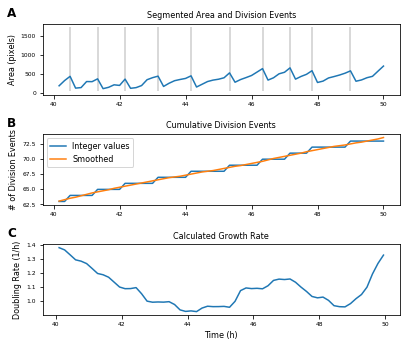

In [71]:
selection = df['id'].unique()
fs = 6
t_cutoff = 69
i = 6

name, t, sig = load_data(i, df)
t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
# calculate growth rate
name, t, t2, area, area2, switch = load_area(i, df)
div = div_events(t, area)
div2 = div_events(t2, area2)
g_rate = growth_rate(t, div, 6)
g_rate2 = growth_rate(t2, div2, 6)
cond = (not switch is None) & (not np.isnan(switch))
if cond:
    g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
    t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
else: 
    g_rate_switch = g_rate
    t_switch = t[:-1]
t_g_interp, g_interp, i_cutoff = sig_interp_nonorm(g_rate_switch, t_switch, t_cutoff, fs)


tstart = 40
tend = 50

fig, axs = plt.subplots(3,1,figsize=(textwidth,.6*textheight))

axs[0].set_title('Segmented Area and Division Events')
axs[0].vlines(div[(div>tstart) & (div<tend)], ymin=np.min(area), ymax=np.max(area), lw=.3)
axs[0].plot(t[tstart*fs:tend*fs], area[tstart*fs:tend*fs])
axs[0].set_ylabel('Area (pixels)')

num_div = np.zeros_like(t)
for t_div in div:
    index = np.argwhere(t == t_div)[0][0]
    num_div[index:] += 1

axs[1].set_title('Cumulative Division Events')
axs[1].plot(t[tstart*fs:tend*fs], num_div[tstart*fs:tend*fs], label='Integer values')
axs[1].plot(t[tstart*fs:tend*fs], savgol_filter(num_div, 17, 1)[tstart*fs:tend*fs], label='Smoothed')
axs[1].legend()
axs[1].set_ylabel('# of Division Events')

axs[2].set_title('Calculated Growth Rate')
axs[2].plot(t_g_interp[tstart*fs:tend*fs], g_interp[tstart*fs:tend*fs])
axs[2].set_xlabel('Time (h)')
axs[2].set_ylabel('Doubling Rate (1/h)')

subplot_labels_oo(axs)
fig.set_tight_layout('tight')

plt.savefig(f'figs/si/{ds}grate.png', dpi=600)
plt.savefig(f'figs/si/{ds}grate.pdf', transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Growth rate: 1.120 +- 0.443


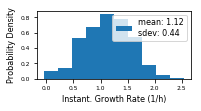

In [18]:
# histograms of g_rate values
selection = df['id'].unique()
fs = 6
t_cutoff = 50

g_rate_values = np.zeros((len(selection),fs*t_cutoff))
for j, i in enumerate(selection):
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)

    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp_nonorm(g_rate_switch, t_switch, t_cutoff, fs)
    g_rate_values[j,:] = g_interp

plt.figure(figsize=(.5*textwidth,.2*textheight))
m = np.mean(g_rate_values.flatten())
s = np.std(g_rate_values.flatten())
a,b,c = plt.hist(g_rate_values.flatten(), density=True, label=f'mean: {m:.2f}\nsdev: {s:.2f}')
plt.legend()
plt.xlabel('Instant. Growth Rate (1/h)')
plt.ylabel('Probability Density')
print(f'Growth rate: {m:.3f} +- {s:.3f}')
plt.tight_layout()

plt.savefig(f'figs/si/{ds}gratehist.png', dpi=600)
plt.savefig(f'figs/si/{ds}gratehist.pdf', transparent=True)

## Mutual Info

### SGA

\\[ I(t;\phi) = \sum_{t_i} P_t(t_i) \sum_{\phi_j} P(\phi_j | t_i) \log_2 \frac{P(\phi_j | t_i)}{P_{\phi}(\phi_j)} \\]

\\[
I(t; \phi) = S[P_{\phi}(\phi)] - \langle  S [ P(\phi | t) ]  \rangle_t
\\]
\\[
S[p(x)] = - \sum_{x_i} p(x_i) \log_2 p(x_i)
\\]

In [73]:
from scipy.stats import norm
from scipy.interpolate import interp1d

def entropy(dist):
    S = 0
    for i, pi in enumerate(dist):
        if np.isinf(np.log2(pi)):
            pass
        else:
            S += -pi*np.log2(pi)
    return S


def calculation(N_t, p_step=0.1, N_samples=72):
    # interpolate in time with N_t discrete steps
    sampling = np.linspace(0,1,N_t)
    period_arr = np.zeros((len(complete_periods), N_t))
    for j in range(len(complete_periods)):
        t = np.linspace(0,1,len(complete_periods[j]))
        interp_func = interp1d(t, complete_periods[j], fill_value='extrapolate', kind='cubic')
        period_arr[j] = interp_func(sampling)
    
    # randomly pick subset of data
    random_choice = np.random.choice(range(period_arr.shape[0]), N_samples, replace=False)
    period_arr_s = period_arr[random_choice, :]
    
    # define distributions
    p_range = np.arange(-3.2, 3.2, p_step) # 
    fs_p=len(p_range)/(p_range.max() - p_range.min())
    t_range = sampling 
    fs_t = len(t_range)
    cond_grid = np.zeros((len(t_range), len(p_range)))
    
    # fill grid with samples from fitted gaussian distribution 
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(period_arr_s[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase; integrate cond_grid over time

    # calculate mutual info
    I = 0
    # entropy from dynamic range
    I += entropy(marg_phase)
    # entropy of noise
    for i, t in enumerate(t_range):
        I += -1*entropy(cond_grid[i,:])/len(t_range)
    return I

# Data
complete_periods = []
for i in range(phases.shape[0]):
    dp = np.diff(phases[i])
    periods = np.where(dp<-6)[0]
    prev = periods[0] + 1
    for p in periods[1:]:
        if (p+1-prev) > 10: # catch outlier
            complete_periods.append(phases[i][prev:p+1])
        prev = p + 1

Extrapolate Mutual Information for unlimited number of samples from limited data

(choose sensible values for discretization in phase and time)

In [74]:
# extrapolate p and t step
#p_step_range = np.arange(0.001,0.5,0.01)
#p_step_I = []

#for p_step in p_step_range:
#    p_step_I.append(calculation(50, N_samples=72, p_step=p_step))

#plt.plot(p_step_range, p_step_I, 'x')

#N_t_range = np.arange(12,73,10)
#N_t_I = []

#for N_t in N_t_range:
#    N_t_I.append(calculation(N_t))

#plt.plot(1/N_t_range, N_t_I, 'x')
#plt.xlim([0, 1/N_t_range.min()])

In [83]:
N_samples_range = (np.array([0.5, 0.75, 0.8, 0.85, 0.9, 0.95])*73).astype(int)

N_samples_I = np.zeros((len(N_samples_range), 100))
for i in range(100):
    for j, N_samples in enumerate(N_samples_range):
        N_samples_I[j, i] = calculation(50, N_samples=N_samples, p_step=0.1)

N_samples_I_m = np.mean(N_samples_I, axis=1)
N_samples_I_err = np.std(N_samples_I, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


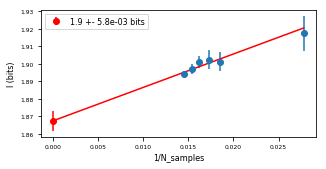

In [84]:
from scipy.optimize import curve_fit
def fitfunc(x, a, b):
    return (a*x + b)
popt, pcov = curve_fit(fitfunc, 1/N_samples_range, N_samples_I_m, sigma=N_samples_I_err)

plt.figure(figsize=(.8*textwidth,.3*textheight))
plt.errorbar(1/N_samples_range, y=N_samples_I_m, yerr=N_samples_I_err/10, fmt='o')
x_range = np.linspace(0, 1/N_samples_range.min(), 1000)
plt.plot(x_range, fitfunc(x_range, *popt), 'r-')
plt.xlabel('1/N_samples')
plt.ylabel('I (bits)')
berr = np.sqrt(np.diag(pcov))[1]
bval = popt[1]
plt.errorbar(0, y=bval, yerr=berr, fmt='ro', label=f'{bval:.2} +- {berr:.1e} bits')
plt.legend(loc=2)

plt.tight_layout()

plt.savefig(f'figs/si/{ds}MIextrap.png', dpi=600)
plt.savefig(f'figs/si/{ds}MIextrap.pdf', transparent=True)